In [1]:
!git clone https://github.com/aliutkus/torchinterp1d.git
!pip install -e /content/torchinterp1d/

fatal: destination path 'torchinterp1d' already exists and is not an empty directory.
Obtaining file:///content/torchinterp1d
  Attempting uninstall: torchinterp1d
    Found existing installation: torchinterp1d 1.1
    Can't uninstall 'torchinterp1d'. No files were found to uninstall.
  Running setup.py develop for torchinterp1d


In [2]:
import numpy as np
import pandas as pd
import torch
from torchinterp1d import Interp1d
import matplotlib.pyplot as plt

In [3]:
def generate_theta(d, L):
    torch.manual_seed(0)
    theta = [th_ / torch.sqrt(torch.sum((th_**2))) for th_ in torch.randn(L, d)]
    return torch.stack(theta, dim=0)
    
def get_slices(X, L):
    _, dim = X.shape
    theta = generate_theta(dim, L)
    return linear_slicer(X, theta)
    
def interpolation(data_sorted, permutation):
    N, L = data_sorted.shape
    M = permutation.shape[0]
    #cdf of sorted dataset.
    Fx = 1 / N * torch.arange(1, N+1).repeat(L,1).T
    z = 1/M*(torch.add(permutation,1))
    #evaluate the inverse of cdf of data_sorted at z
    interp = Interp1d()(Fx.T, data_sorted.T, z.T)
    # return the monge copuling with shape M*L
    return interp.T

def monge_coupling(dataset, reference, L):
    sliced_data = get_slices(dataset, L)
    sliced_ref = get_slices(reference, L)
    
    data_sorted,_ = torch.sort(sliced_data, dim=0)
    ref_ind = torch.argsort(sliced_ref, dim=0)
    permutation = torch.argsort(ref_ind, dim=0)
    if dataset.shape[0] == reference.shape[0]:
       coupling = data_sorted.T[torch.arange(L).unsqueeze(1).repeat((1, dataset.shape[0])).flatten(), permutation.T.flatten()].view(L, dataset.shape[0]).T
    else: coupling = interpolation(data_sorted, permutation)
  
    return coupling
    
def sw_embedding(dataset, reference, L):
    M = torch.tensor(reference.shape[0])
    #return the final embedding
    return 1/torch.sqrt(M)*(monge_coupling(dataset, reference, L)-get_slices(reference, L))

def linear_slicer(X, theta):
    #g_\theta(x)=\theta^T*x
    if len(theta.shape)==1:
        return torch.matmul(X,theta)
    else:
        return torch.matmul(X,theta.T)

In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test.csv")

In [5]:
X = df_train[df_train.columns[1:]].to_numpy()
y = df_train[df_train.columns[0]].to_numpy()
X = X.reshape(X.shape[0], -1, 3)
X = torch.from_numpy(X).to(torch.float)
y = torch.from_numpy(y).to(torch.float)

In [6]:
sample_dataset = []
for i in range(100):
    sample = X[i, :, :]
    sample = sample[sample[:, 2] > 0][:, :2]
    sample_dataset.append(sample)

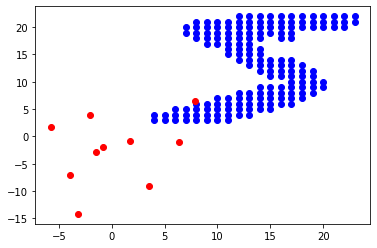

In [7]:
torch.manual_seed(123)
a = sample_dataset[0]
ref = torch.randn(10,2)*5
plt.scatter(a[:,0], a[:,1], c='b')
plt.scatter(ref[:,0], ref[:,1], c='r')

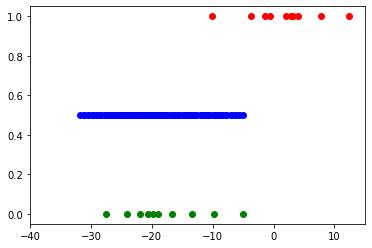

In [8]:
torch.manual_seed(23)
ref1 = get_slices(ref,20)[:,0]
a1 = get_slices(a,20)[:,0]
mc= monge_coupling(a, ref, 20)
mc1 = mc[:,0]
#visualizing monge coupling
plt.xlim(-40, 15)
plt.scatter(ref1, torch.ones(10,1), c='r') #first slice of ref
plt.scatter(a1, torch.ones(166,1)*0.5,c='b') #first slice of sample
plt.scatter(mc1, torch.zeros(10,1),c='g') #monge map between them

In [9]:
class SlicedWD:
    def __call__(self, x, y, L, p=2, random_state=0):
        self.p = p
        assert x.device == y.device
        self.state = random_state
        self.device = x.device
        self.num_slices = L
        return self.sliced_wasserstein(x, y, L)

    def sample_on_unit_sphere(self, d, L):
        # sampling points on the d-dimensional unit sphere
        torch.manual_seed(self.state)
        theta = [th_ / torch.sqrt(torch.sum((th_**2))) for th_ in torch.randn(L, d, device=self.device)]
        return torch.stack(theta, dim=0)
    
    def interpolate_samples(self, proj_x_sorted, proj_y_sorted):
        num_samples_x = proj_x_sorted.shape[0]
        num_samples_y = proj_y_sorted.shape[0]

        fx = 1 / num_samples_x * torch.ones(num_samples_x, self.num_slices)
        fy = 1 / num_samples_y * torch.ones(num_samples_y, self.num_slices)

        Fx = torch.cumsum(fx, dim=0)
        Fy = torch.cumsum(fy, dim=0)

        M = max(num_samples_x, num_samples_y)
        m = min(num_samples_x, num_samples_y)
        z = torch.linspace(1/m, 1, m).repeat(self.num_slices, 1)

        x_interp = Interp1d()(Fx.T, proj_x_sorted.T, z)
        y_interp = Interp1d()(Fy.T, proj_y_sorted.T, z)

        return x_interp.T, y_interp.T

    def wasserstein_1d(self, proj_x, proj_y):
        # W_p^p for 1D slices of x and y
        proj_x_sorted, _ = torch.sort(proj_x, dim=0)
        proj_y_sorted, _ = torch.sort(proj_y, dim=0)

        if proj_x.shape != proj_y.shape:
            proj_x_sorted, proj_y_sorted = self.interpolate_samples(proj_x_sorted, proj_y_sorted)

        cost = torch.abs(proj_x_sorted - proj_y_sorted) ** self.p
        
        return torch.mean(cost, dim=0)


    def sliced_wasserstein(self, x, y, L):
        # sliced wasserstein distance between x and y using L slices
        N, d = x.shape
        theta = self.sample_on_unit_sphere(d, L)
        proj_x = torch.matmul(x, theta.T)
        proj_y = torch.matmul(y, theta.T)
        swd = torch.sqrt(torch.sum(self.wasserstein_1d(proj_x, proj_y)))
        return swd
    

In [10]:
#checking the swe and the swd
b = sample_dataset[1]
swe1 = sw_embedding(a, ref, 10)
swe2 = sw_embedding(b, ref, 10)
swd = SlicedWD()(a, b, 10)
print(torch.norm(swe1-swe2, p='fro'))
print(swd)


tensor(3.7720)
tensor(3.6891)
